#  Прогнозирование заказов такси

Данное исследование будет проводиться на основании исторических данных о заказах такси компании «Чётенькое такси» в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. При этом значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## 1. Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
RANDOM_STATE=0

Загрузим данные

In [3]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Отсортируем данные по дате и проведем ресемплирование

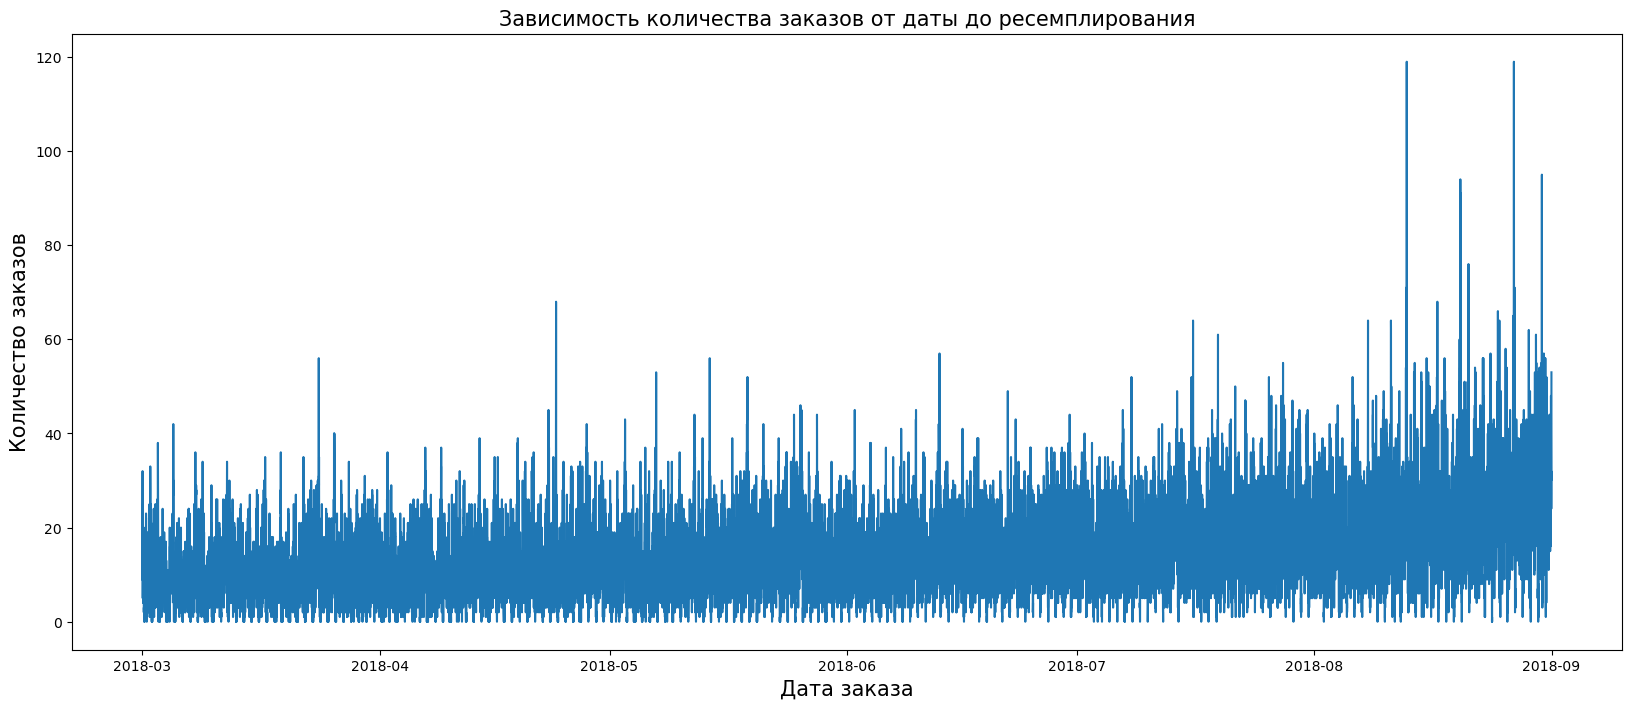

In [6]:
data.sort_index(inplace=True)
plt.figure(figsize=[20, 8])
plt.plot(data)
plt.title('Зависимость количества заказов от даты до ресемплирования', fontsize=15)
plt.xlabel('Дата заказа', fontsize=15)
plt.ylabel('Количество заказов', fontsize=15)
plt.show()

In [7]:
data = data.resample('1H').sum()

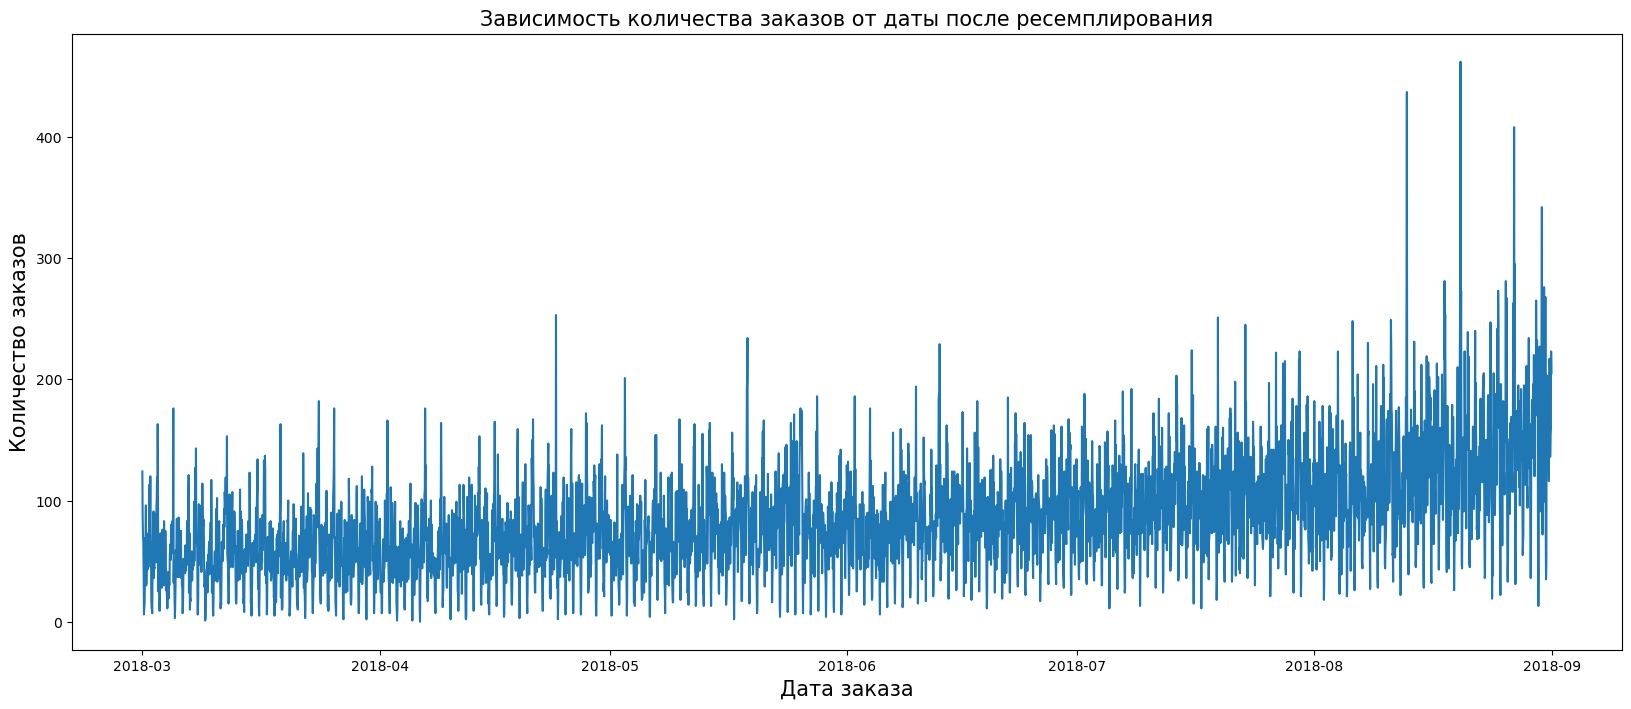

In [8]:
data.sort_index(inplace=True)
plt.figure(figsize=[20, 8])
plt.plot(data)
plt.title('Зависимость количества заказов от даты после ресемплирования', fontsize=15)
plt.xlabel('Дата заказа', fontsize=15)
plt.ylabel('Количество заказов', fontsize=15)
plt.show()

Проведем сезонную декомпозицию. Построим график тренда и сезонности

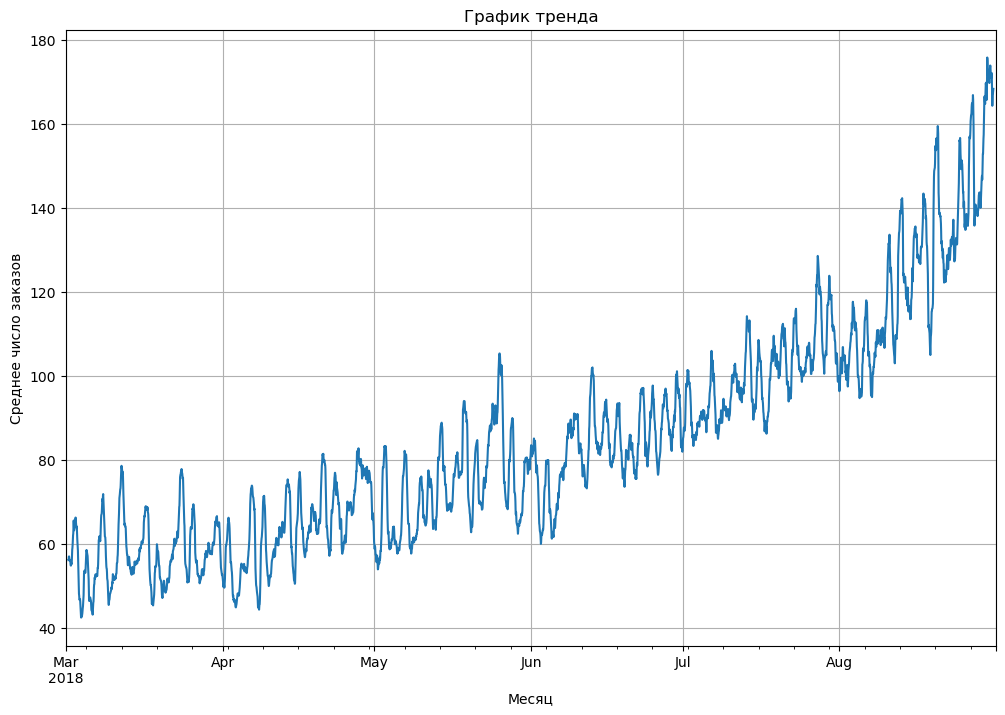

In [9]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(12,8))
decomposed.trend.plot()
plt.title('График тренда')
plt.xlabel('Месяц')
plt.ylabel('Среднее число заказов')
plt.grid(axis='both')
plt.show()

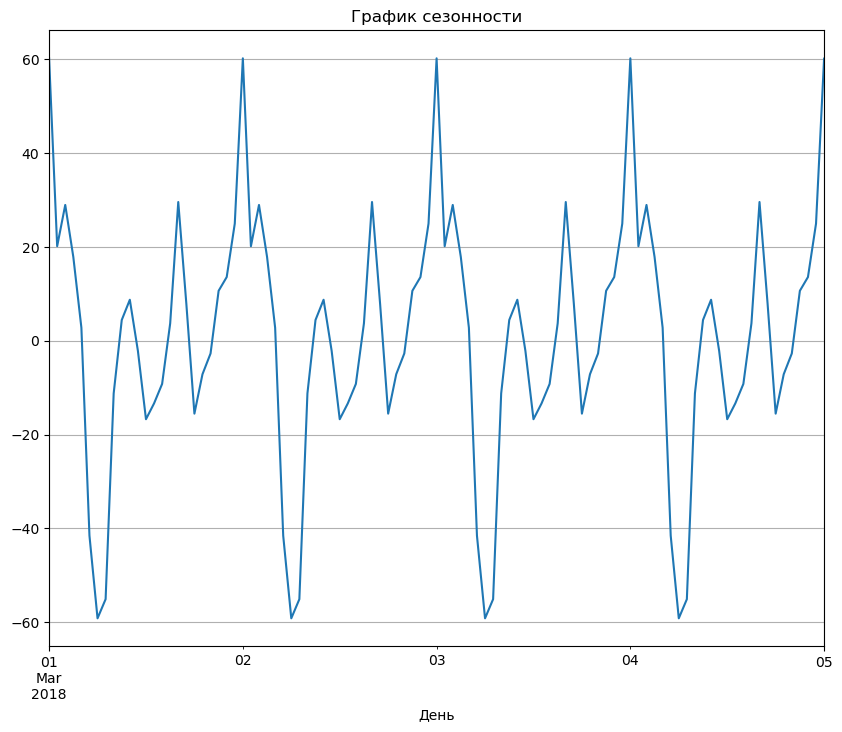

In [10]:
plt.figure(figsize=(10,8))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('График сезонности')
plt.xlabel('День')
plt.grid(axis='both')
plt.xlim(['2018-03-01 00:00:00', '2018-03-05 00:00:00'])
plt.show()

По графику тренда видно, как рост числа заказов такси до июня не значителен, а вот далее заметен значительный рост. Период сезонности данных равен одному дню

Теперь создадим функцию для получения новых признаков (месяца, дня, дня недели и часа, а также с отстающими значениями)

In [11]:
def make_features(df, max_lag):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['hour'] = df.index.hour
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)
    return df.dropna()

In [12]:
data = make_features(data, 3)

In [13]:
data.head()

,num_orders,month,day,day_of_week,hour,lag_1,lag_2,lag_3
datetime,,,,,,,,
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0


Подготовим выборки для обучения модели предсказаний, выбора лучшей из них и итоговой проверки. Разделим исходный набор данных на подвыборки в соотношении 8:1:1

In [14]:
train, other = train_test_split(data, train_size=.8, shuffle=False)
valid, test = train_test_split(other, train_size=.5, shuffle=False)
train_features = train.drop(['num_orders'], axis=1)
valid_features = valid.drop(['num_orders'], axis=1)
test_features = test.drop(['num_orders'], axis=1)
train_target = train['num_orders']
valid_target = valid['num_orders']
test_target = test['num_orders']

In [15]:
print(train.shape, valid.shape, test.shape)

(3530, 8) (441, 8) (442, 8)


В итоге, на этапе подготовки были сделаны следующие шаги:
1. Загрузили данные;
2. В качестве индекса записей была выбрана дата;
3. Выполнили ресемплирование данных по часам;
4. Добавили новые признаки в данные: месяц, день, день недели и час когда был сделан заказ, а также признаки с тремя предшествующими значениями заказов;
5. Разделили исходный набор данных на тренировочную, валидационную и тестовуб выборки в соотношении 8:1:1

## 2. Анализ

Еще раз посмотрим на рспределение числа заказов на всем временном промежутке

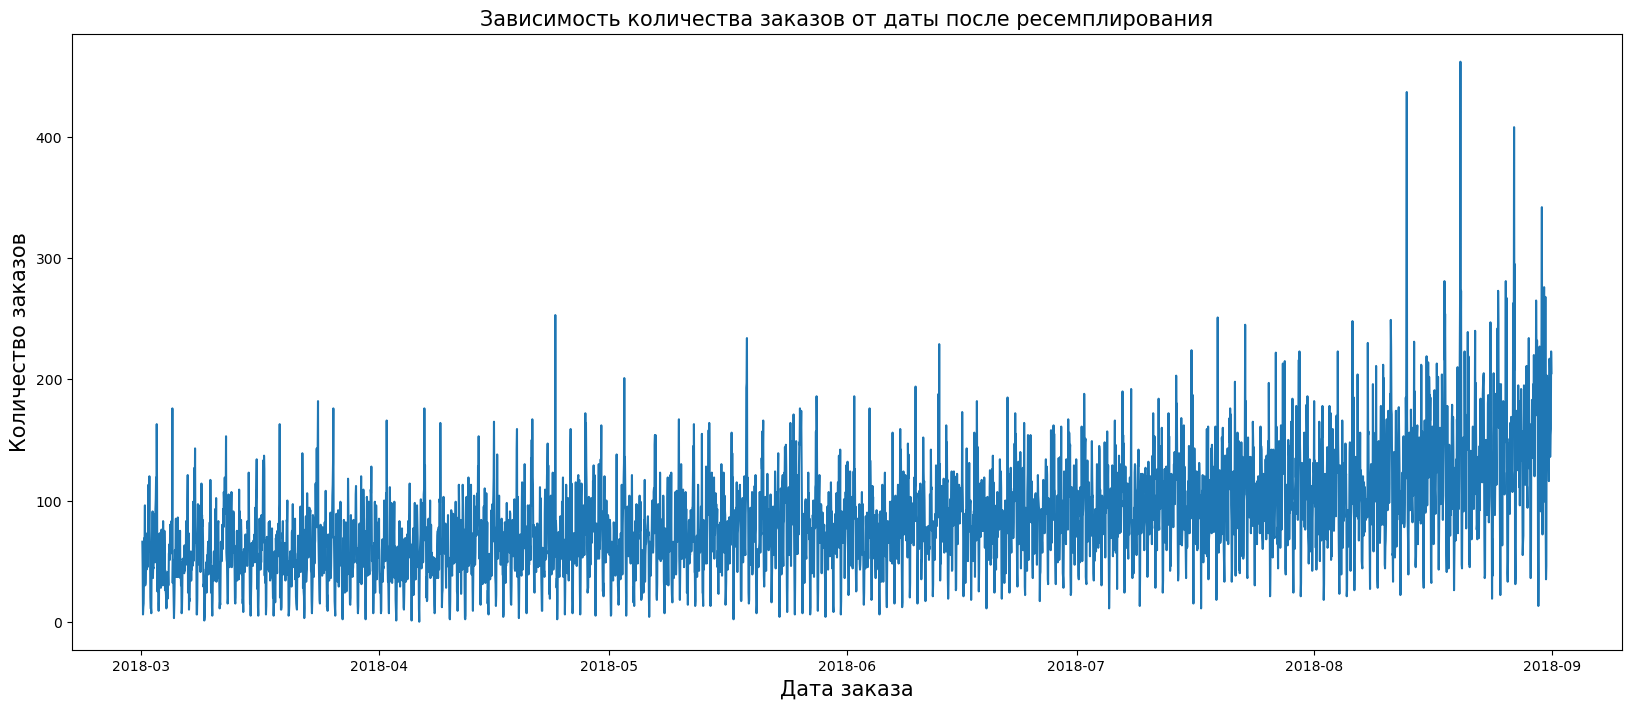

In [16]:
plt.figure(figsize=[20, 8])
plt.plot(data['num_orders'])
plt.title('Зависимость количества заказов от даты после ресемплирования', fontsize=15)
plt.xlabel('Дата заказа', fontsize=15)
plt.ylabel('Количество заказов', fontsize=15)
plt.show()

Видно, что, начиная примерно с июня, число заказов начинает рости, при этом растут и колебания этой величины. Рассмотрим распределения чуть глубже. Возьмем распределение числа заказов по месяцам

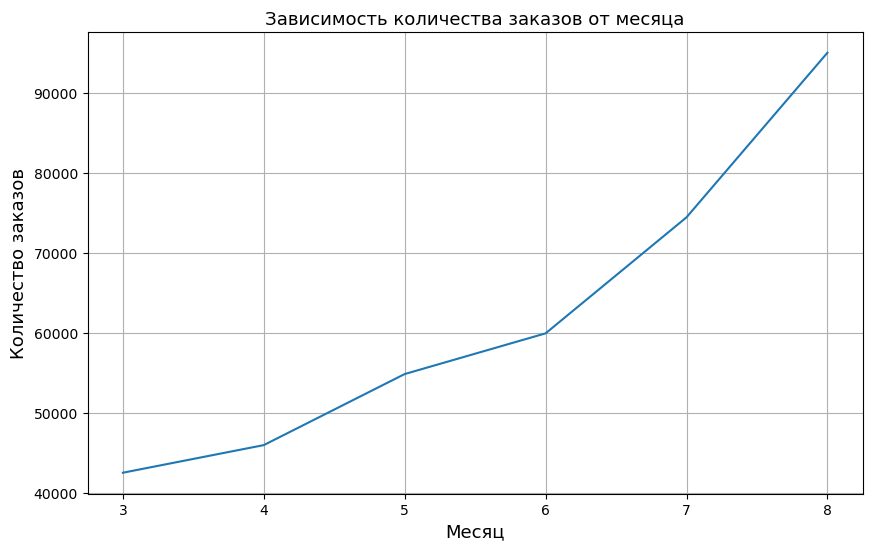

In [17]:
plt.figure(figsize=[10, 6])
plt.plot(data.groupby(['month'])['num_orders'].sum())
plt.title('Зависимость количества заказов от месяца', fontsize=13)
plt.xlabel('Месяц', fontsize=13)
plt.ylabel('Количество заказов', fontsize=13)
plt.grid(axis='both')
plt.show()

Подтвердились предыдущий промежуточный вывод, что до июня число заказов постепенно растет, а затем заметен резкий рост. Теперь рассмотрим распределение по дням недели.

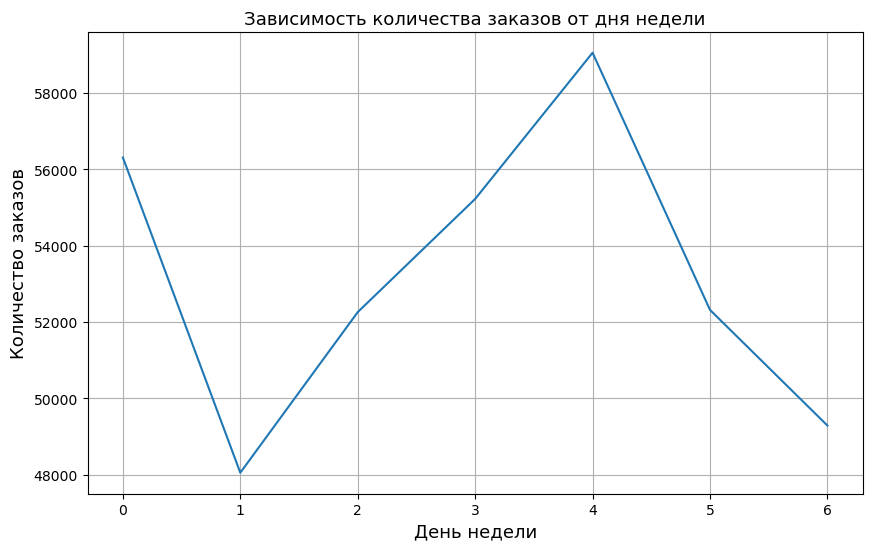

In [18]:
plt.figure(figsize=[10, 6])
plt.plot(data.groupby(['day_of_week'])['num_orders'].sum())
plt.title('Зависимость количества заказов от дня недели', fontsize=13)
plt.xlabel('День недели', fontsize=13)
plt.ylabel('Количество заказов', fontsize=13)
plt.grid(axis='both')
plt.show()

Самые наименее популярные дни недели заказа такси - это вторник и воскресенье, при этом чаще вссего такси заказывают в пятницу, чуть меньше в понедельник и четверг. Рассмотрим распределение заказов по часам.

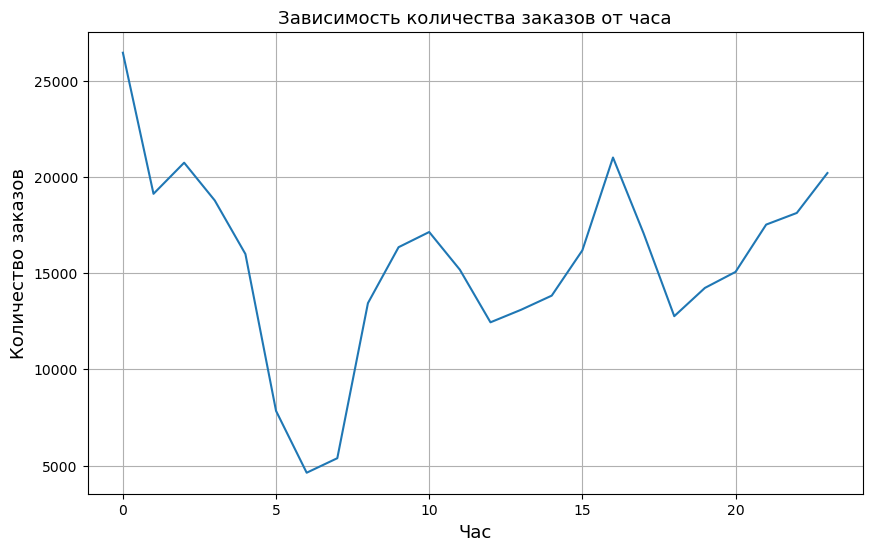

In [19]:
plt.figure(figsize=[10, 6])
plt.plot(data.groupby(['hour'])['num_orders'].sum())
plt.title('Зависимость количества заказов от часа', fontsize=13)
plt.xlabel('Час', fontsize=13)
plt.ylabel('Количество заказов', fontsize=13)
plt.grid(axis='both')
plt.show()

Самое большое количество заказов происходит в промежутке с 23:00 до 1:00. После 2:00 идет резкиий спад. Также стоит отметить популярность поездок на такси с 7:00 до 10:00 и с 14:00 до 17:00

На этапе анализа в ходе исследования распределения числа заказов от различных параметров выяснили:
1. До июня число заказов постепенно растет, а затем заметен резкий рост;
2. Самые наименее популярные дни недели заказа такси - это вторник и воскресенье, при этом чаще вссего такси заказывают в пятницу, чуть меньше в понедельник и четверг;
3. Самое большое количество заказов происходит в промежутке с 23:00 до 1:00. После 2:00 идет резкиий спад. Также стоит отметить популярность поездок на такси с 7:00 до 10:00 и с 14:00 до 17:00

## 3. Обучение

Начнем обучать различные модели. Начнем с линейной регрессии

In [20]:
model_lin_reg = LinearRegression()
model_lin_reg.fit(train_features, train_target)
pred_lin_reg = model_lin_reg.predict(valid_features)
rmse_lin_reg = mean_squared_error(valid_target, pred_lin_reg) ** .5
print(f'RMSE для линейной регрессии: {rmse_lin_reg}')

RMSE для линейной регрессии: 40.78865062550755


Теперь посмотрим на случайный лес

In [21]:
best_rmse_forest = 100
best_depth_forest = 0
best_est_forest = 0
for est in tqdm(range(1, 200, 10)):
    for depth in range(1, 10, 1):
        model_forest = RandomForestRegressor(max_depth=depth, n_estimators=est, random_state=RANDOM_STATE)
        model_forest.fit(train_features, train_target)
        pred_forest = model_forest.predict(valid_features)
        rmse_forest = mean_squared_error(valid_target, pred_forest) ** .5
        if rmse_forest < best_rmse_forest:
            best_est_forest = est
            best_rmse_forest = rmse_forest
            best_depth_forest = depth
print(f'Наилучшая модель имеет глубину дерева {best_depth_forest} с числом деревьев {best_est_forest}\
\nЗначение метрики RMSE: {best_rmse_forest}')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:08<00:00,  3.43s/it]

Наилучшая модель имеет глубину дерева 9 с числом деревьев 191
Значение метрики RMSE: 33.58537140798985


Обучим дерево решений

In [22]:
best_rmse_tree = 100
best_depth_tree = 0
for depth in tqdm(range(1, 100, 1)):
    model_tree = DecisionTreeRegressor(max_depth=depth, random_state=RANDOM_STATE)
    model_tree.fit(train_features, train_target)
    pred_tree = model_tree.predict(valid_features)
    rmse_tree = mean_squared_error(valid_target, pred_tree) ** .5
    if rmse_tree < best_rmse_tree:
        best_rmse_tree = rmse_tree
        best_depth_tree = depth
print(f'Наилучшая модель имеет глубину дерева {best_depth_tree}\nЗначение метрики RMSE: {best_rmse_tree}')

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:01<00:00, 68.11it/s]

Наилучшая модель имеет глубину дерева 6
Значение метрики RMSE: 36.64782731752897


Обучим одну модель градиентного бустинга, а именно модель LightGBM

In [23]:
best_est_lgbm = 0
best_leave_lgbm = 0
best_rmse_lgbm = 10000
for est in tqdm(range(1, 200, 10)):
    for leave in range(2, 60, 5):
        model_lgbm = LGBMRegressor(num_leaves=leave, n_estimators=est, verbose=-1)
        model_lgbm.fit(train_features, train_target)
        pred_lgbm = model_lgbm.predict(valid_features)
        rmse_lgbm = mean_squared_error(valid_target, pred_lgbm) ** .5
        if rmse_lgbm < best_rmse_lgbm:
            best_est_lgbm = est
            best_leave_lgbm = leave
            best_rmse_lgbm = rmse_lgbm
print(f'Наилучшая модель с гиперпараметрами num_leaves={best_leave_lgbm}, n_estimators={best_est_lgbm}.\
Получили метрику RMSE={best_rmse_lgbm}')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.27it/s]

Наилучшая модель с гиперпараметрами num_leaves=12, n_estimators=181.Получили метрику RMSE=32.3808247185745


Посмотрим теперь, какая модель лучше всего справилась

In [24]:
info = [[rmse_lin_reg], [best_rmse_forest], [best_rmse_tree], [best_rmse_lgbm]]
results_of_models = pd.DataFrame(info, columns=['RMSE'], index=['Линейная регрессия', 'Случайный лес', 'Дерево решений', 'LGBM']) 
results_of_models

,RMSE
Линейная регрессия,40.788651
Случайный лес,33.585371
Дерево решений,36.647827
LGBM,32.380825


На этапе обучения моделей были проделаны следующие шаги:
1. Обучены 4 модели для предсказания (линейная регрессия, случайный лес, дерево решений и градиентный бустинг);
2. Для каждой модели были подобраны наилучшие гиперпараметры;
3. Из четырех обученных моделей была выбрана модель, показавшая наилучшую матрику RMSE на валидационной выборке, а именно модель градиентного бустинга LGBM с метрикой RMSE равной примерно 32.4

## Тестирование

Проведем итоговое тестирование выбранной в предыдущем разделе модели, а именно градиентного бустинга LGBM

In [25]:
model = LGBMRegressor(num_leaves=12, n_estimators=181, verbose=-1)
model.fit(pd.concat([train_features,valid_features]), pd.concat([train_target,valid_target]))
pred = model.predict(test_features)
rmse = mean_squared_error(test_target, pred) ** .5
print(f'Градиентный бустинг с гиперпараметрами num_leaves=12, n_estimators=181 имеет метрику RMSE={rmse}')

Градиентный бустинг с гиперпараметрами num_leaves=12, n_estimators=181 имеет метрику RMSE=42.597463990264266


Выбранная модель имеет метрику RMSE на тестовой выборке 42.6, что удовлетворяет поставленному условию для верхнего порога данной метрики

#### ВЫВОД. 

В ходе нашего исследования были изучены исходные данные компании «Чётенькое такси» о заказах такси в аэропортах. К этому датасету были добавлены такие признаки, как месяц, день, день недели и час когда был сделан заказ, а также признаки с тремя предшествующими значениями заказов. Также все данные были ресемплированы по часам. 

В ходе анализа данных выяснили, что самые наименее популярные дни недели заказа такси - это вторник и воскресенье, при этом чаще вссего такси заказывают в пятницу. Также стоит отметить, что самое большое количество заказов происходит в промежутке с 23:00 до 1:00. После 2:00 идет резкиий спад. Ну и на конец до июня число заказов постепенно растет, а затем заметен резкий рост. 

Далее были обучены различные модели для предсказаний числа заказов. Среди таких моделей линейная регрессия (метрика RMSE равна 40.79), дерево решений (метрика RMSE равна 36.65), случайный лес (метрика RMSE равна 33.59) и градиентный бустинг LGBM (метрика RMSE равна 32.38). По результатм сравнения метрик для итогового тестирования была выбрана модель градиентного бустинга. На тестовых данных эта модель показала метрику RMSE, равную 42.6, что удовлетворяет поставленному условию для верхнего порога данной метрики в 48